In [22]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

In [23]:
import numpy as np
from abc import ABC, abstractmethod
from typing import List, Tuple, Any
import matplotlib.pyplot as plt

class CustomDistribution(ABC):
    """
    Abstract base class for custom parametrized distributions.
    Subclasses must implement:
    - pdf: Probability density/mass function
    - initialize_params: Parameter initialization
    - update_params: M-step parameter update
    """
    
    @abstractmethod
    def pdf(self, x: np.ndarray, params: Any) -> np.ndarray:
        """
        Compute probability density/mass for data points x.
        
        Args:
            x: Data points (shape: [n_samples, n_features])
            params: Distribution parameters
            
        Returns:
            Probabilities (shape: [n_samples])
        """
        pass
    
    @abstractmethod
    def initialize_params(self, X: np.ndarray) -> Any:
        """
        Initialize parameters using data X.
        
        Args:
            X: Observed data (shape: [n_samples, n_features])
            
        Returns:
            Initialized parameters
        """
        pass
    
    @abstractmethod
    def update_params(self, X: np.ndarray, weights: np.ndarray) -> Any:
        """
        Update parameters using weighted data (M-step).
        
        Args:
            X: Observed data (shape: [n_samples, n_features])
            weights: Responsibilities (shape: [n_samples])
            
        Returns:
            Updated parameters
        """
        pass

class EMAlgorithm:
    """
    EM Algorithm for mixture of N custom parametrized distributions.
    """
    
    def init(self, distributions: List[CustomDistribution], 
                 n_components: int, 
                 max_iter: int = 100, 
                 tol: float = 1e-6,
                 random_state: int = None):
        """
        Initialize EM algorithm.
        
        Args:
            distributions: List of N distribution objects (one per component)
            n_components: Number of mixture components (N)
            max_iter: Maximum number of iterations
            tol: Convergence tolerance
            random_state: Random seed for reproducibility
        """
        if len(distributions) != n_components:
            raise ValueError("Number of distributions must match n_components")
            
        self.distributions = distributions
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        
        # Initialize random state
        if random_state is not None:
            np.random.seed(random_state)
            
        # Model parameters
        self.params_ = None      # List of parameters for each component
        self.weights_ = None     # Mixture weights (pi)
        self.log_likelihoods_ = []  # Log-likelihood history
        
    def fit(self, X: np.ndarray) -> 'EMAlgorithm':
        """
        Fit the EM algorithm to data X.
        
        Args:
            X: Observed data (shape: [n_samples, n_features])
            
        Returns:
            Self (fitted model)
        """
        X = np.asarray(X)
        n_samples = X.shape[0]
        
        # Step 1: Initialize parameters
        self.params_ = []
        for dist in self.distributions:
            self.params_.append(dist.initialize_params(X))
            
        # Initialize mixture weights uniformly
        self.weights_ = np.full(self.n_components, 1.0 / self.n_components)
        
        # EM iterations
        prev_log_likelihood = -np.inf
        
        for iteration in range(self.max_iter):
            # E-step: Compute responsibilities
            responsibilities = self._e_step(X)
            print(iteration,' resp:',responsibilities.shape)
            fig=plt.figure(figsize=(10,3))
            plt.subplot(1,3,1)
            csc=plt.scatter(X[:,0],X[:,1],c=responsibilities[:,0])
            plt.colorbar(csc)
            plt.subplot(1,3,2)
            csc=plt.scatter(X[:,0],X[:,1],c=responsibilities[:,1])
            plt.colorbar(csc)
            plt.subplot(1,3,3)
            csc=plt.scatter(X[:,0],X[:,1],c=responsibilities[:,2])
            plt.colorbar(csc)
            plt.show()

            # M-step: Update parameters
            self._m_step(X, responsibilities)
            
            # Compute log-likelihood
            log_likelihood = self._compute_log_likelihood(X)
            self.log_likelihoods_.append(log_likelihood)
            
            # Check convergence
            if np.abs(log_likelihood - prev_log_likelihood) < self.tol:
                print(f"Converged at iteration {iteration}")
                break
                
            prev_log_likelihood = log_likelihood
            
        return self
    
    def _e_step(self, X: np.ndarray) -> np.ndarray:
        """
        E-step: Compute responsibilities (posterior probabilities).
        
        Args:
            X: Observed data (shape: [n_samples, n_features])
            
        Returns:
            Responsibilities (shape: [n_samples, n_components])
        """
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))
        
        # Compute unnormalized responsibilities
        for k in range(self.n_components):
            pdf_vals = self.distributions[k].pdf(X, self.params_[k])
            responsibilities[:, k] = self.weights_[k] * pdf_vals
            
        # Normalize responsibilities
        row_sums = responsibilities.sum(axis=1, keepdims=True)
        # Handle zero probabilities (add small epsilon for numerical stability)
        row_sums = np.where(row_sums == 0, 1e-15, row_sums)
        responsibilities /= row_sums
        
        return responsibilities
    
    def _m_step(self, X: np.ndarray, responsibilities: np.ndarray) -> None:
        """
        M-step: Update parameters and mixture weights.
        
        Args:
            X: Observed data (shape: [n_samples, n_features])
            responsibilities: Responsibilities from E-step (shape: [n_samples, n_components])
        """
        n_samples = X.shape[0]
        
        # Update mixture weights
        self.weights_ = responsibilities.sum(axis=0) / n_samples
        
        # Update distribution parameters
        for k in range(self.n_components):
            self.params_[k] = self.distributions[k].update_params(
                X, responsibilities[:, k]
            )
    
    def _compute_log_likelihood(self, X: np.ndarray) -> float:
        """
        Compute log-likelihood of the data.
        
        Args:
            X: Observed data (shape: [n_samples, n_features])
            
        Returns:
            Log-likelihood value
        """
        n_samples = X.shape[0]
        log_likelihood = 0.0
        
        for i in range(n_samples):
            prob = 0.0
            for k in range(self.n_components):
                pdf_val = self.distributions[k].pdf(X[i:i+1], self.params_[k])
                prob += self.weights_[k] * pdf_val[0]
            # Add small epsilon to avoid log(0)
            log_likelihood += np.log(prob + 1e-15)
            
        return log_likelihood
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict component labels for data X.
        
        Args:
            X: Data to predict (shape: [n_samples, n_features])
            
        Returns:
            Predicted component labels (shape: [n_samples])
        """
        responsibilities = self._e_step(X)
        return np.argmax(responsibilities, axis=1)
    
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Predict posterior probabilities for data X.
        
        Args:
            X: Data to predict (shape: [n_samples, n_features])
            
        Returns:
            Posterior probabilities (shape: [n_samples, n_components])
        """
        return self._e_step(X)

# Example: Custom Gaussian Distribution
class GaussianDistribution(CustomDistribution):
    """Gaussian distribution with mean and covariance parameters."""
    
    def __init__(self, n_features: int):
        self.n_features = n_features
        
    def pdf(self, x: np.ndarray, params: Tuple[np.ndarray, np.ndarray]) -> np.ndarray:
        mean, cov = params
        n = x.shape[0]
        diff = x - mean
        # Compute multivariate normal PDF
        cov_inv = np.linalg.inv(cov)
        cov_det = np.linalg.det(cov)
        norm_const = 1.0 / np.sqrt((2 * np.pi) ** self.n_features * cov_det)
        exp_term = np.exp(-0.5 * np.sum(diff @ cov_inv * diff, axis=1))
        return norm_const * exp_term
    
    def initialize_params(self, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        # Initialize with random mean and identity covariance
        mean = X[np.random.choice(X.shape[0])]
        cov = np.eye(self.n_features) * np.var(X)
        return (mean.copy(), cov.copy())
    
    def update_params(self, X: np.ndarray, weights: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        # Weighted mean and covariance
        total_weight = np.sum(weights)
        if total_weight == 0:
            # Fallback if no responsibility assigned
            mean = np.mean(X, axis=0)
            cov = np.cov(X.T)
        else:
            mean = np.average(X, axis=0, weights=weights)
            diff = X - mean
            cov = np.dot(weights * diff.T, diff) / total_weight
            # Add small regularization to ensure positive definiteness
            cov += np.eye(self.n_features) * 1e-6
        return (mean, cov)

# Example usage
  # Generate synthetic data
np.random.seed(42)
n_samples = 300
n_features = 2

# Component 1
X1 = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1]], n_samples//3)
# Component 2
X2 = np.random.multivariate_normal([3, 3], [[1, -0.3], [-0.3, 1]], n_samples//3)
# Component 3
X3 = np.random.multivariate_normal([-2, 3], [[0.5, 0], [0, 2]], n_samples//3)
Y= np.array([0]*X1.shape[0]+[1]*X2.shape[0]+[2]*X3.shape[0])
X = np.vstack([X1, X2, X3])
print(X.shape,Y.shape)

# Create custom distributions (3 Gaussian components)
distributions = [
    GaussianDistribution(n_features),
    GaussianDistribution(n_features),
    GaussianDistribution(n_features)
]

# Fit EM algorithm
em = EMAlgorithm(
    distributions=distributions,
    n_components=3,
    max_iter=100,
    tol=1e-6,
    random_state=42
)

em.fit(X)

# Print results
print("Mixture weights:", em.weights_)
print("Log-likelihood history length:", len(em.log_likelihoods_))
print("Final log-likelihood:", em.log_likelihoods_[-1])

# Predict labels
labels = em.predict(X)
print("Predicted labels shape:", labels.shape)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y,labels))
#plt.scatter(X[:,0],X[:,1],c=Y)
#plt.show()
%pip install mlxtend
from mlxtend.plotting import plot_decision_regions
plt.figure(figsize=(5,5))
plot_decision_regions(X, Y.astype(int), clf=em, legend=2)
plt.show()

(300, 2) (300,)


TypeError: EMAlgorithm() takes no arguments

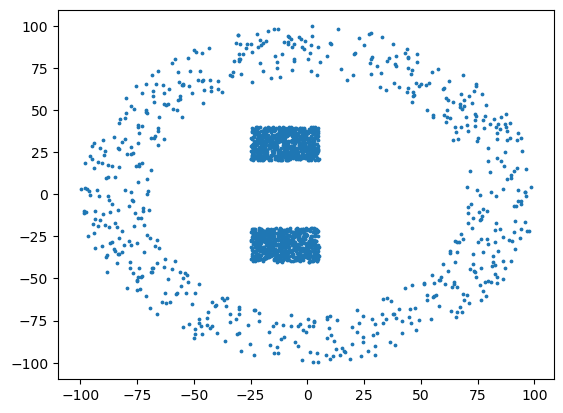

In [24]:
#Иерархический алгоритм
# Кластеризация
f = open('src2.dat')
d = []
for s in f:
  d.append([float(x) for x in s.split()])
d = np.array(d)
plt.scatter(d[:, 0], d[:, 1], s = 3)
plt.show()



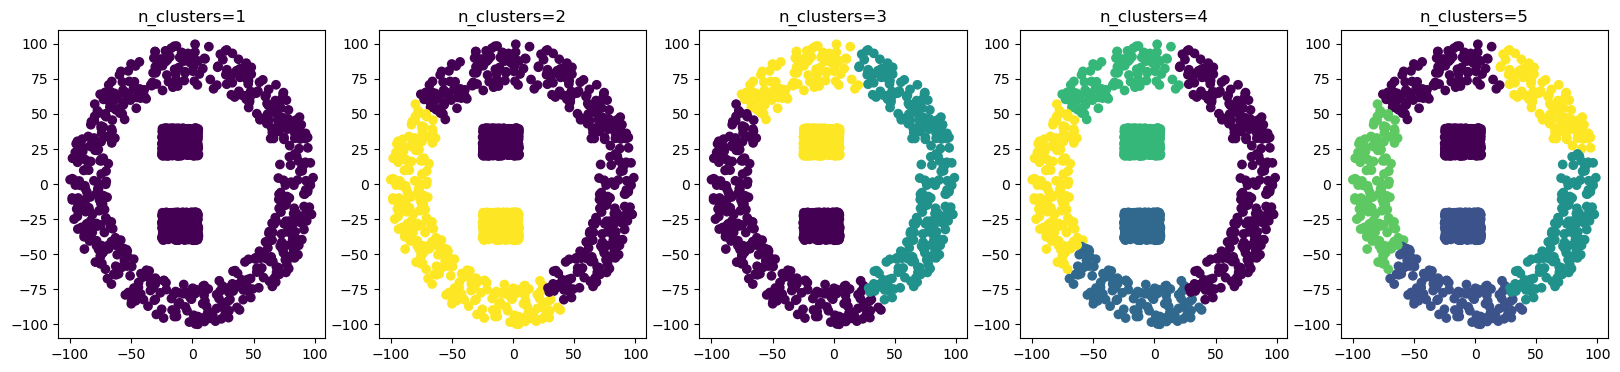

In [30]:
from sklearn.cluster import AgglomerativeClustering
num = 1
fig, axs = plt.subplots(1, 5, figsize = (20, 4))
for i in range(1, 6):
  clf = AgglomerativeClustering(n_clusters=i)
  c = clf.fit_predict(d)
  axs[i-1].scatter(d[:,0], d[:,1], c=c)
  axs[i-1].set_title(f'n_clusters={i}')
  num +=1
plt.show()

In [ ]:
#Комбинационные алгоритмы
from gmsdb import GMSDB #DOWNLOAD
clf = GMSDB(n_components = 10)
c = clf.fit_predict(d)
plt.scatter(d[:, 0], d[:, 1], c = c)
plt.show()